# Prepare all the Library we are going to use

In [1]:
!pip install wandb

In [2]:
import torch

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

from transformers import BertTokenizer,BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.utils import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.utils import resample
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import wandb
wandb.login(key="dfe65521d10dd2bef25317d1db135f11698fe624")

2026-01-19 12:57:29.948484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768827450.143986      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768827450.201582      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyenlamhuy0002 (nguyenlamhuy0002-i-h-c-qu-c-gia-tp-hcm) to https://api.w

True

## Using GPU for training

In [3]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Prepare for Dataset

### Import the dataset and split it to train, val and test set.

In [4]:
train_df = pd.read_csv("/kaggle/input/emotion-dataset/training.csv")
valid_df = pd.read_csv("/kaggle/input/emotion-dataset/validation.csv")
test_df = pd.read_csv("/kaggle/input/emotion-dataset/test.csv")

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

BATCH_SIZE = 32
MAX_LEN = 100

(16000, 2)
(2000, 2)
(2000, 2)


In [5]:
total_df = pd.concat([train_df, valid_df, test_df])

# EDA the Dataset

### Show the number of samples of each labels

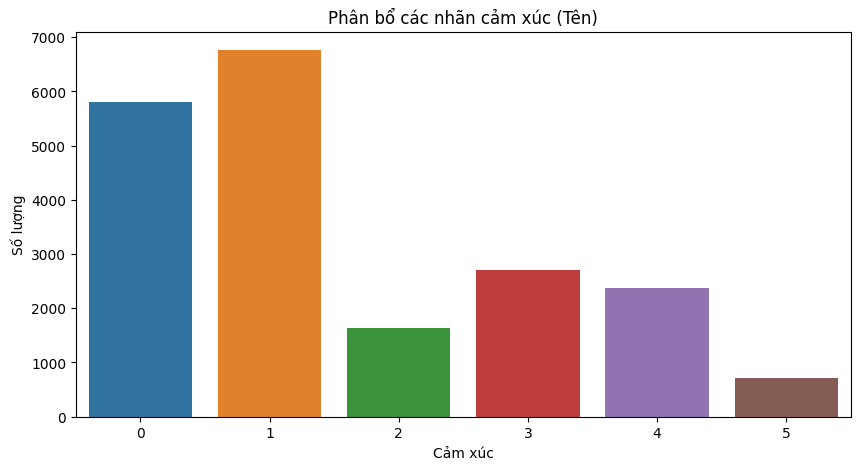

In [6]:
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

plt.figure(figsize=(10, 5))
# Vẽ countplot
ax = sns.countplot(x='label', data=total_df)

# Thay đổi tên trên trục X
ax.set_xticklabels(emotion_map)

plt.title('Phân bổ các nhãn cảm xúc (Tên)')
plt.xlabel('Cảm xúc')
plt.ylabel('Số lượng')
plt.show()

## Show 5 samples of each label

In [7]:
for label_idx, label_name in emotion_map.items():
    print(f"\n" + "="*30)
    print(f"CẢM XÚC: {label_name.upper()} (Label {label_idx})")
    print("="*30)
    
    samples = total_df[total_df['label'] == label_idx]['text'].head(5)
    
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")


CẢM XÚC: SADNESS (Label 0)
1. i didnt feel humiliated
2. i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
3. ive been feeling a little burdened lately wasnt sure why that was
4. i feel like i have to make the suffering i m seeing mean something
5. i feel low energy i m just thirsty

CẢM XÚC: JOY (Label 1)
1. i have been with petronas for years i feel that petronas has performed well and made a huge profit
2. i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
3. i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious
4. i do not feel reassured anxiety is on each side
5. i have the feeling she was amused and delighted

CẢM XÚC: LOVE (Label 2)
1. i am ever feeling nostalgic about the fireplace i will know that 

### Create WordCloud for each label

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

def get_top_keywords_table(df, n_top=10):
    emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    # Danh sách từ dừng (stopwords) bổ sung để lọc bớt từ vô nghĩa
    custom_stopwords = ['feel', 'feeling', 'like', 'im', 'really', 'know', 'get', 'make', 'time', 'little', 'ive', 'just']
    
    keywords_dict = {}

    for label_idx, label_name in emotion_map.items():
        # Lấy toàn bộ văn bản của nhãn này
        text_data = df[df['label'] == label_idx]['text']
        
        # Sử dụng CountVectorizer để đếm tần suất từ
        vec = CountVectorizer(stop_words='english').fit(text_data)
        bag_of_words = vec.transform(text_data)
        sum_words = bag_of_words.sum(axis=0) 
        
        # Tạo danh sách (từ, tần suất)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() 
                      if word not in custom_stopwords]
        
        # Sắp xếp và lấy n_top từ đầu tiên
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n_top]
        
        # Lưu vào dict dưới dạng: Word (Frequency)
        keywords_dict[label_name.upper()] = [f"{word} ({count})" for word, count in words_freq]

    # Chuyển đổi thành DataFrame để hiển thị dạng bảng
    keywords_df = pd.DataFrame(keywords_dict)
    
    print(f"--- Top {n_top} Từ Khóa Quan Trọng Theo Từng Cảm Xúc ---")
    display(keywords_df)

# Chạy hàm với DataFrame của bạn
get_top_keywords_table(total_df, n_top=10)

--- Top 10 Từ Khóa Quan Trọng Theo Từng Cảm Xúc ---


,SADNESS,JOY,LOVE,ANGER,FEAR,SURPRISE
0,want (235),people (265),love (119),people (144),bit (143),amazed (83)
1,life (218),want (250),sweet (84),want (124),people (100),impressed (72)
2,bit (215),good (241),loving (82),think (109),want (95),curious (72)
3,people (213),think (235),want (80),angry (106),strange (92),overwhelmed (69)
4,think (213),pretty (235),people (80),things (104),anxious (92),funny (68)
5,things (191),life (232),caring (78),bit (102),terrified (89),surprised (68)
6,dont (190),love (231),passionate (75),way (101),nervous (89),weird (67)
7,day (169),going (218),sympathetic (72),don (93),think (87),strange (59)
8,going (159),day (203),life (71),dont (91),going (86),amazing (56)
9,way (155),happy (190),liked (70),cold (86),afraid (85),shocked (52)


## Prepare Dataloader

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def convert_to_dataloader(df, is_training=False):
    # Sử dụng tokenizer để trả về input_ids và attention_mask
    encoded_dict = tokenizer(
        df['text'].tolist(),
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Tạo TensorDataset
    dataset = TensorDataset(
        encoded_dict['input_ids'], 
        encoded_dict['attention_mask'], 
        torch.tensor(df['label'].values)
    )
    
    # Chọn Sampler: Random cho Train để tăng tính tổng quát, Sequential cho Valid/Test
    sampler = RandomSampler(dataset) if is_training else SequentialSampler(dataset)
    
    return DataLoader(dataset, sampler=sampler, batch_size=BATCH_SIZE)

training_dataloader = convert_to_dataloader(train_df, is_training=True)
validation_dataloader = convert_to_dataloader(valid_df)
test_dataloader = convert_to_dataloader(test_df)

print("Đã tạo xong các DataLoader!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Đã tạo xong các DataLoader!


In [10]:
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding='max_length', max_length=100, return_tensors='pt')
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding='max_length', max_length=100, return_tensors='pt')
test_encodings  = tokenizer(test_df['text'].tolist(), truncation=True, padding='max_length', max_length=100, return_tensors='pt')

# Gán tên biến chính xác
train_ids, train_mask = train_encodings['input_ids'], train_encodings['attention_mask']
valid_ids, valid_mask = valid_encodings['input_ids'], valid_encodings['attention_mask']
test_ids, test_mask   = test_encodings['input_ids'],  test_encodings['attention_mask']

train_labels = torch.tensor(train_df['label'].values)
valid_labels = torch.tensor(valid_df['label'].values)
test_labels  = torch.tensor(test_df['label'].values)

In [11]:
# Tạo DataLoader cho tập Training (Dùng RandomSampler để trộn dữ liệu)
train_dataset = TensorDataset(train_ids, train_mask, train_labels)
training_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=BATCH_SIZE
)

# Tạo DataLoader cho tập Validation (Dùng để theo dõi khi đang Train)
valid_dataset = TensorDataset(valid_ids, valid_mask, valid_labels)
validation_dataloader = DataLoader(
    valid_dataset, 
    sampler=SequentialSampler(valid_dataset), 
    batch_size=BATCH_SIZE
)

# Tạo DataLoader cho tập Test (Dùng một lần duy nhất sau khi Train xong)
test_dataset = TensorDataset(test_ids, test_mask, test_labels)
test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=BATCH_SIZE
)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)

        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        """
        x: (batch, seq_len, d_model)
        attention_mask: (batch, 1, 1, seq_len)
        """
        B, T, C = x.shape

        qkv = self.qkv(x)                           # (B, T, 3C)
        qkv = qkv.reshape(B, T, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)            # (3, B, heads, T, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, T, T)

        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.attn_dropout(attn)

        out = attn @ v                              # (B, heads, T, head_dim)
        out = out.transpose(1, 2).contiguous()      # (B, T, heads, head_dim)
        out = out.view(B, T, C)

        return self.proj_dropout(self.out(out))

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        return self.fc2(self.dropout(self.activation(self.fc1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.attn = MultiHeadSelfAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        # Self-attention block
        x = x + self.dropout(self.attn(x, attention_mask))
        x = self.norm1(x)

        # Feed-forward block
        x = x + self.dropout(self.ffn(x))
        x = self.norm2(x)

        return x

class BERT(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_len=512,
        d_model=768,
        num_layers=12,
        num_heads=12,
        d_ff=3072,
        dropout=0.1
    ):
        super().__init__()

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.segment_embedding = nn.Embedding(2, d_model)

        self.dropout = nn.Dropout(dropout)

        # Encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        """
        input_ids: (batch, seq_len)
        attention_mask: (batch, seq_len) -> 1 = keep, 0 = pad
        token_type_ids: (batch, seq_len)
        """
        B, T = input_ids.shape

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # Create position ids
        position_ids = torch.arange(T, device=input_ids.device).unsqueeze(0)

        # Embedding sum
        x = (
            self.token_embedding(input_ids)
            + self.position_embedding(position_ids)
            + self.segment_embedding(token_type_ids)
        )

        x = self.dropout(x)

        # Prepare attention mask
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            # (B, 1, 1, T)

        # Encoder stack
        for layer in self.layers:
            x = layer(x, attention_mask)

        return self.norm(x)

class BERTForClassification(nn.Module):
    def __init__(self, bert_model, num_labels):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Lấy đầu ra từ backbone (Custom BERT hoặc Hugging Face BertModel)
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        
        # Kiểm tra định dạng đầu ra để lấy last_hidden_state
        # Hugging Face trả về object, Custom trả về trực tiếp Tensor
        if hasattr(outputs, 'last_hidden_state'):
            last_hidden_state = outputs.last_hidden_state  # Dành cho Pretrained
        elif isinstance(outputs, (list, tuple)):
            last_hidden_state = outputs[0]                 # Phòng trường hợp trả về tuple
        else:
            last_hidden_state = outputs                    # Dành cho Custom BERT
        
        # Trích xuất token [CLS] tại vị trí index 0
        # Hình dạng: (batch_size, 768)
        cls_output = last_hidden_state[:, 0, :]
        
        # Phân loại
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits

In [13]:
labels = train_df['label'].values
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(labels), 
    y=labels
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

def train_model(model, training_dataloader, validation_dataloader,
                optimizer, scheduler, device, epochs):

    # Thêm 'train_acc' vào history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_mcc': []}

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1} / {epochs} ---")

        # ================= TRAIN =================
        model.train()
        total_train_loss = 0
        all_train_preds, all_train_labels = [], [] # Khởi tạo danh sách để tính Accuracy

        for batch in training_dataloader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

            model.zero_grad()

            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, b_labels)

            total_train_loss += loss.item()
            loss.backward()

            # Lưu dự đoán để tính Train Accuracy
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(b_labels.cpu().numpy())

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Tính toán các chỉ số Train
        avg_train_loss = total_train_loss / len(training_dataloader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # ================= VALID =================
        model.eval()
        total_eval_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in validation_dataloader:
                b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

                outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, b_labels)

                total_eval_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(b_labels.cpu().numpy())

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_mcc = matthews_corrcoef(all_labels, all_preds)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_mcc'].append(val_mcc)

        # ================= W&B LOG =================
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "val_loss": avg_val_loss,
            "val_accuracy": val_acc,
            "val_mcc": val_mcc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(
            f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | MCC: {val_mcc:.4f}"
        )

    return history

In [14]:
backbones = {
    "BERT_Pretrained": BertModel.from_pretrained('bert-base-uncased'),
    "BERT_Custom": BERT(vocab_size=30522)
}

all_histories = {}

for name, backbone in backbones.items():
    print(f"\n" + "="*30)
    print(f"BẮT ĐẦU HUẤN LUYỆN: {name}")
    print("="*30)
    
    # 1. Khởi tạo mô hình phân loại (Lớp Wrapper bạn đã viết)
    model = BERTForClassification(backbone, num_labels=6)
    model.to(device)

    if(name == "BERT_Pretrained"):
        EPOCHS = 3
    else:
        EPOCHS = 10

    
    # 2. Khởi tạo Optimizer & Scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    total_steps = len(training_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )

    # 3. Khởi tạo W&B cho mỗi lần chạy (Sửa model_name thành name)
    wandb.init(
        project="kaggle-text-classification",
        name=f"{name}-run", # Đã sửa
        config={
            "model_architecture": name, # Đã sửa
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE if 'BATCH_SIZE' in locals() else 32,
            "learning_rate": 2e-5,
            "optimizer": optimizer.__class__.__name__,
            "scheduler": scheduler.__class__.__name__
        },
        reinit=True
    )

    wandb.watch(model, log="gradients", log_freq=100) # Đã sửa
    
    # 4. Huấn luyện
    
    history = train_model(
        model, 
        training_dataloader, 
        validation_dataloader, 
        optimizer, 
        scheduler, 
        device, 
        EPOCHS
    )
    
    all_histories[name] = history

    torch.save(model.state_dict(), f"model_{name}.pth")
    
    # Kết thúc và dọn dẹp bộ nhớ
    wandb.finish()
    del model
    torch.cuda.empty_cache()

print("\n--- TẤT CẢ QUY TRÌNH HUẤN LUYỆN ĐÃ HOÀN TẤT ---")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


BẮT ĐẦU HUẤN LUYỆN: BERT_Pretrained


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



--- Epoch 1 / 3 ---
Train Loss: 0.6250 | Train Acc: 0.7626 | Val Loss: 0.2075 | Val Acc: 0.9220 | MCC: 0.8991

--- Epoch 2 / 3 ---
Train Loss: 0.1693 | Train Acc: 0.9348 | Val Loss: 0.1765 | Val Acc: 0.9280 | MCC: 0.9072

--- Epoch 3 / 3 ---
Train Loss: 0.1162 | Train Acc: 0.9500 | Val Loss: 0.1736 | Val Acc: 0.9285 | MCC: 0.9074


epoch,▁▅█
learning_rate,█▅▁
train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▂▁
val_mcc,▁██
epoch,3
learning_rate,0
train_accuracy,0.95
train_loss,0.11619



BẮT ĐẦU HUẤN LUYỆN: BERT_Custom



--- Epoch 1 / 10 ---
Train Loss: 1.8584 | Train Acc: 0.1734 | Val Loss: 1.7792 | Val Acc: 0.1565 | MCC: 0.0656

--- Epoch 2 / 10 ---
Train Loss: 1.6626 | Train Acc: 0.2421 | Val Loss: 1.3110 | Val Acc: 0.3505 | MCC: 0.2620

--- Epoch 3 / 10 ---
Train Loss: 1.1640 | Train Acc: 0.4557 | Val Loss: 0.9450 | Val Acc: 0.5980 | MCC: 0.4754

--- Epoch 4 / 10 ---
Train Loss: 0.8434 | Train Acc: 0.6042 | Val Loss: 0.6649 | Val Acc: 0.7080 | MCC: 0.6292

--- Epoch 5 / 10 ---
Train Loss: 0.6128 | Train Acc: 0.7124 | Val Loss: 0.5724 | Val Acc: 0.7390 | MCC: 0.6733

--- Epoch 6 / 10 ---
Train Loss: 0.4848 | Train Acc: 0.7686 | Val Loss: 0.4864 | Val Acc: 0.7755 | MCC: 0.7229

--- Epoch 7 / 10 ---
Train Loss: 0.4050 | Train Acc: 0.8090 | Val Loss: 0.4218 | Val Acc: 0.8255 | MCC: 0.7774

--- Epoch 8 / 10 ---
Train Loss: 0.3476 | Train Acc: 0.8339 | Val Loss: 0.4053 | Val Acc: 0.8270 | MCC: 0.7809

--- Epoch 9 / 10 ---
Train Loss: 0.3132 | Train Acc: 0.8528 | Val Loss: 0.3978 | Val Acc: 0.8460 | MCC:

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▆▆▅▄▃▃▂▁
train_accuracy,▁▂▄▅▆▇▇███
train_loss,█▇▅▄▂▂▂▁▁▁
val_accuracy,▁▃▅▇▇▇████
val_loss,█▆▄▂▂▁▁▁▁▁
val_mcc,▁▃▅▆▇▇████
epoch,10
learning_rate,0
train_accuracy,0.86444
train_loss,0.27667



--- TẤT CẢ QUY TRÌNH HUẤN LUYỆN ĐÃ HOÀN TẤT ---


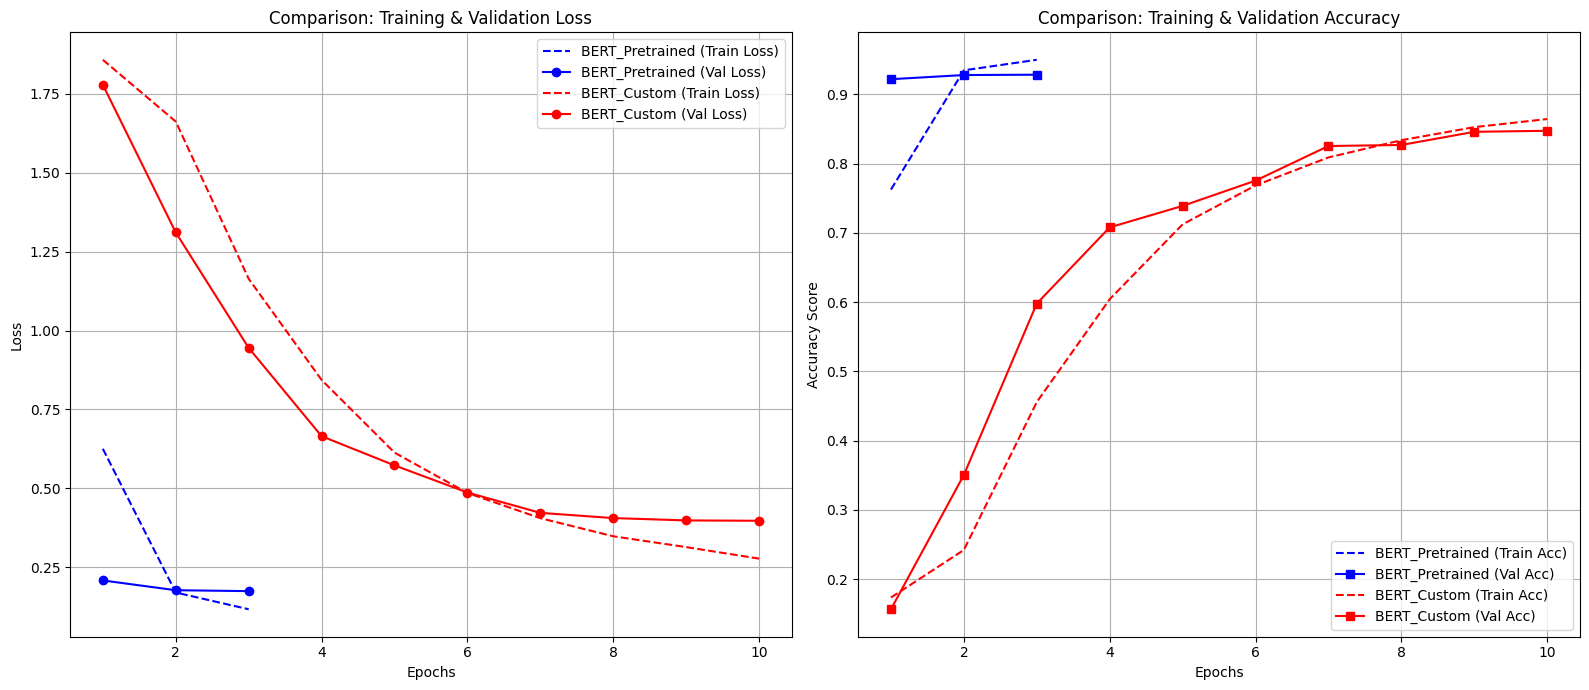

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 7))

model_names = list(all_histories.keys())
colors = ['blue', 'red', 'green', 'orange']

# --- BIỂU ĐỒ LOSS (SO SÁNH TRAIN & VAL) ---
plt.subplot(1, 2, 1)
for i, name in enumerate(model_names):
    hist = all_histories[name]
    epochs = range(1, len(hist['train_loss']) + 1)
    
    # Vẽ Train Loss (nét đứt) và Val Loss (nét liền)
    plt.plot(epochs, hist['train_loss'], '--', color=colors[i], label=f"{name} (Train Loss)")
    plt.plot(epochs, hist['val_loss'], '-o', color=colors[i], label=f"{name} (Val Loss)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison: Training & Validation Loss")
plt.legend()
plt.grid(True)

# --- BIỂU ĐỒ ACCURACY (SO SÁNH TRAIN & VAL) ---
plt.subplot(1, 2, 2)
for i, name in enumerate(model_names):
    hist = all_histories[name]
    epochs = range(1, len(hist['train_acc']) + 1)
    
    # Vẽ Train Acc (nét đứt) và Val Acc (nét liền)
    plt.plot(epochs, hist['train_acc'], '--', color=colors[i], label=f"{name} (Train Acc)")
    plt.plot(epochs, hist['val_acc'], '-s', color=colors[i], label=f"{name} (Val Acc)")

plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.title("Comparison: Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


ĐANG ĐÁNH GIÁ MÔ HÌNH: BERT_Custom

[BÁO CÁO PHÂN LOẠI: BERT_Custom]
              precision    recall  f1-score   support

     sadness       0.84      0.82      0.83       581
         joy       0.88      0.78      0.83       695
        love       0.66      0.85      0.74       159
       anger       0.82      0.88      0.85       275
        fear       0.86      0.85      0.85       224
    surprise       0.57      0.82      0.68        66

    accuracy                           0.82      2000
   macro avg       0.77      0.83      0.80      2000
weighted avg       0.83      0.82      0.82      2000



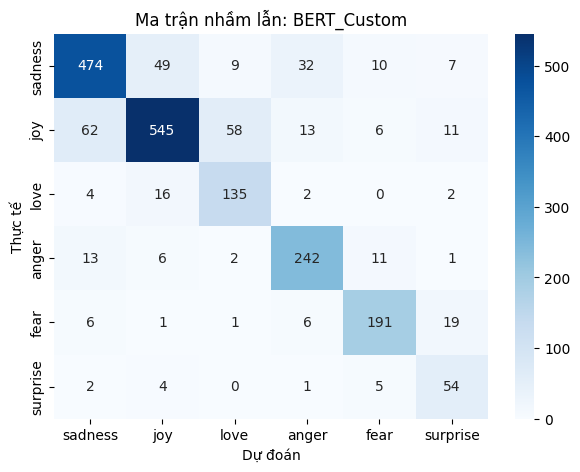


ĐANG ĐÁNH GIÁ MÔ HÌNH: BERT_Pretrained

[BÁO CÁO PHÂN LOẠI: BERT_Pretrained]
              precision    recall  f1-score   support

     sadness       0.97      0.96      0.96       581
         joy       0.98      0.91      0.95       695
        love       0.77      0.96      0.85       159
       anger       0.90      0.93      0.92       275
        fear       0.88      0.88      0.88       224
    surprise       0.70      0.77      0.73        66

    accuracy                           0.92      2000
   macro avg       0.87      0.90      0.88      2000
weighted avg       0.93      0.92      0.92      2000



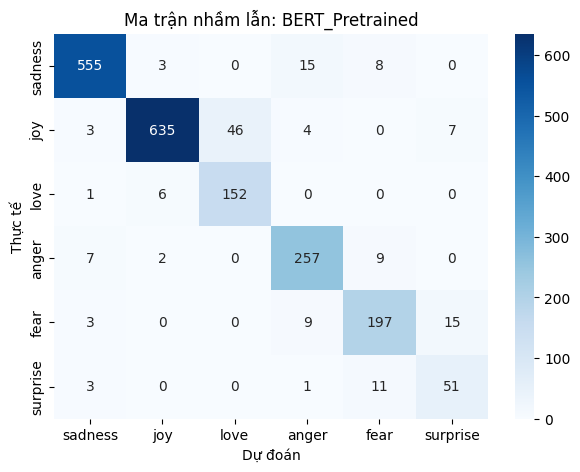

In [16]:
def evaluate_multiple_models(models_dict, test_dataloader, device):
    """
    models_dict: Dictionary chứa { "Tên Model": đối_tượng_model }
    """
    target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    
    for model_name, model in models_dict.items():
        print(f"\n" + "="*50)
        print(f"ĐANG ĐÁNH GIÁ MÔ HÌNH: {model_name}")
        print("="*50)
        
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in test_dataloader:
                b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

                outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
                
                # Logic xử lý linh hoạt Logits
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(b_labels.cpu().numpy())

        print(f"\n[BÁO CÁO PHÂN LOẠI: {model_name}]")
        print(classification_report(all_labels, all_preds, target_names=target_names))

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.title(f'Ma trận nhầm lẫn: {model_name}')
        plt.show()

# Khởi tạo thực thể trống
model_custom = BERTForClassification(BERT(vocab_size=30522), num_labels=6).to(device)
model_pretrained = BERTForClassification(BertModel.from_pretrained('bert-base-uncased'), num_labels=6).to(device)

# Nạp trọng số đã train vào (đảm bảo file .pth tồn tại trong thư mục làm việc)
model_custom.load_state_dict(torch.load("model_BERT_Custom.pth"))
model_pretrained.load_state_dict(torch.load("model_BERT_Pretrained.pth"))

models_to_test = {
    "BERT_Custom": model_custom,
    "BERT_Pretrained": model_pretrained
}

evaluate_multiple_models(models_to_test, test_dataloader, device)

In [ ]:
def interactive_prediction_comparison(models_dict, tokenizer, device):
    """
    models_dict: Dictionary chứa {'Tên Model': đối_tượng_model}
    """
    print("--- So sánh dự đoán cảm xúc (Gõ 'exit' để thoát) ---")
    emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    
    while True:
        user_input = input("\nNhập câu văn tiếng Anh: ")
        
        if user_input.lower() == 'exit':
            print("Đang thoát...")
            print("Đã thoát thành công!")
            break
            
        if not user_input.strip():
            continue

        # Tokenize một lần duy nhất cho cả 2 model
        inputs = tokenizer(
            user_input, 
            return_tensors="pt", 
            truncation=True, 
            max_length=100, 
            padding='max_length'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        print("-" * 30)
        for name, model in models_dict.items():
            model.eval()
            with torch.no_grad():
                # Thực hiện dự đoán
                outputs = model(**inputs)
                
                # Xử lý linh hoạt cho cả Custom và Pre-trained
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                
                probs = torch.nn.functional.softmax(logits, dim=1)
                conf, pred = torch.max(probs, dim=1)
                
                emotion_result = emotions[pred.item()]
                confidence = conf.item() * 100
                
                print(f"[{name}] >> Dự đoán: {emotion_result} ({confidence:.2f}%)")
        print("-" * 30)

comparison_models = {
    "BERT_Custom": model_custom,
    "BERT_Pretrained": model_pretrained
}

interactive_prediction_comparison(comparison_models, tokenizer, device)

--- So sánh dự đoán cảm xúc (Gõ 'exit' để thoát) ---
